In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import zscore
from statsmodels.stats.multitest import multipletests
import warnings

warnings.simplefilter(action='ignore')

from src.connectomics.atlases import get_dk_rois
from src.analysis.stats import ols_comparison
from src.analysis.misc import set_plot_style, add_significance
from src.analysis.plots import plot_regression
from src.analysis.surf import assign_val2roi, plot_surface

set_plot_style(dpi=150)
ROIs = get_dk_rois()

# in
data_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'data'))
df_dir = os.path.join(data_dir, 'datasets')

# out
media_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'media'))

plot_dir = os.path.join(media_dir, '_plots')
surfplot_dir = os.path.join(plot_dir, 'surfs')
os.makedirs(surfplot_dir, exist_ok=True)

### read BF2 data

amy_prefix = 'fnc'
tau_prefix = 'tnic'
grp_col = 'temporal_meta_tau_asymmetry_group'
covars = ['age', 'gender_baseline_variable', 'diagnosis_baseline_variable']

df_fname = os.path.join(df_dir, f'bf2_tau_asymmetry_ad_t_xs_{tau_prefix}_{amy_prefix}_mri.csv')
df_bf2 = pd.read_csv(df_fname, low_memory=False, index_col=0)

cols = ['sid', 'mid', grp_col] + covars + [col for col in df_bf2.columns if col.startswith((amy_prefix, tau_prefix, 'aparc_ct_'))]
df_bf2 = df_bf2[cols].copy()
print(f"N (xs) = {df_bf2.shape}")

df = df_bf2.copy()
df['ci'] = df['diagnosis_baseline_variable'].map({'Normal': 0, 'SCD': 0, 'MCI': 1, 'AD': 1})

N (xs) = (452, 1910)


                            OLS Regression Results                            
Dep. Variable:         tnic_global_LI   R-squared:                       0.399
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     50.61
Date:                Mon, 28 Apr 2025   Prob (F-statistic):           3.94e-25
Time:                        14:35:56   Log-Likelihood:                -271.36
No. Observations:                 233   AIC:                             550.7
Df Residuals:                     229   BIC:                             564.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

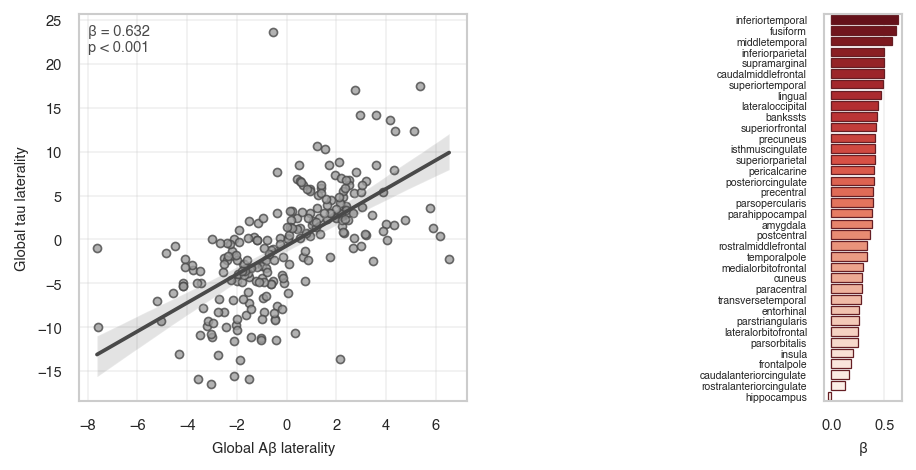

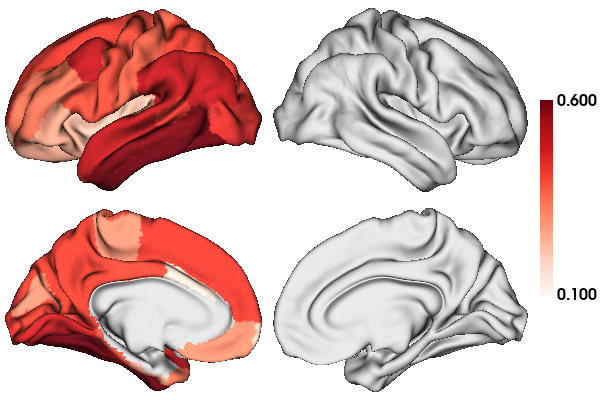

fdr-sig p-vals: min=0.0, mean=0.001, max=0.012
fdr-sig betas: min=0.167, mean=0.38, max=0.633


{'caudalanteriorcingulate': 0.167,
 'frontalpole': 0.185,
 'insula': 0.208,
 'parsorbitalis': 0.248,
 'lateralorbitofrontal': 0.248,
 'parstriangularis': 0.261,
 'entorhinal': 0.264,
 'transversetemporal': 0.275,
 'paracentral': 0.292,
 'cuneus': 0.293,
 'medialorbitofrontal': 0.299,
 'temporalpole': 0.334,
 'rostralmiddlefrontal': 0.336,
 'postcentral': 0.361,
 'Amygdala': 0.384,
 'parahippocampal': 0.384,
 'parsopercularis': 0.392,
 'precentral': 0.395,
 'posteriorcingulate': 0.401,
 'pericalcarine': 0.407,
 'superiorparietal': 0.411,
 'isthmuscingulate': 0.414,
 'precuneus': 0.414,
 'superiorfrontal': 0.424,
 'bankssts': 0.428,
 'lateraloccipital': 0.442,
 'lingual': 0.469,
 'superiortemporal': 0.492,
 'caudalmiddlefrontal': 0.495,
 'supramarginal': 0.495,
 'inferiorparietal': 0.496,
 'middletemporal': 0.571,
 'fusiform': 0.613,
 'inferiortemporal': 0.633}

non-sig betas:


{'Hippocampus': -0.034, 'rostralanteriorcingulate': 0.13}

non-sig pvals:


{'rostralanteriorcingulate': 0.051, 'Hippocampus': 0.608}

In [3]:
grp_colors = {'LA': '#5785C1FF', 'LA-S': '#ff6961', 'S': '#D3D4D8FF', 'RA-S': '#ff6961', 'RA': '#FBA72AFF'}
statann_kwargs = dict(fontsize=7, color='#494949')
scatter_kwargs = dict(s=15, lw=0.8, alpha=0.8, edgecolor='#494949', color='#9f9f9f')
legend_kwargs = dict(loc='best', title='Tau asymmetry', title_fontsize=7)
strip_kwargs = dict(linewidth=0.8, size=3, alpha=0.8, edgecolor='#494949')
box_kwargs = dict(alpha=0.95, lw=0.8)
pval_kwargs = dict(lw=0.8, fontsize=7, col='#494949', h_coef=0.015, y_coef=0.1)

fig = plt.figure(figsize=(155.5/25.4, 80/25.4))
gs = fig.add_gridspec(1, 3, width_ratios=[5, 1, 1])
ax_left, ax_middle, ax_right = fig.add_subplot(gs[0]), fig.add_subplot(gs[1]), fig.add_subplot(gs[2])

# subplot for regression between Ab vs tau lateralities

y = f'{tau_prefix}_global_LI'
ylabel = 'Global tau laterality'

x = f'{amy_prefix}_global_LI'
xlabel = 'Global Aβ laterality'

df_ = df.dropna(subset=[x, y])

covars = ['age', 'gender_baseline_variable']

_, ax_left, model = plot_regression(df=df_, x=x, y=y, covars=covars, standardise=True,
                               ax=ax_left, xlabel=xlabel, ylabel=ylabel, 
                               text_kwargs=statann_kwargs, scatter_kwargs=scatter_kwargs)
print(model.summary())

# empty subplot for surface plot

ax_middle.axis('off')

fnc_li_cols = [col for col in df.columns if ('LI' in col and 'fnc' in col and any(region in col for region in ROIs['global']))]
tnic_li_cols = [col for col in df.columns if ('LI' in col and 'tnic' in col and any(region in col for region in ROIs['global']))]

df_ = df.dropna(subset=fnc_li_cols+tnic_li_cols)

fnc_tnic_b = {}
for region in ROIs['global']:
    # find matching columns for the current region
    fnc_col = next((col for col in fnc_li_cols if region in col), None)
    tnic_col = next((col for col in tnic_li_cols if region in col), None)
    
    try:
        # prepare data and optionally z-score
        df_v = df_[[fnc_col, tnic_col] + ['age', 'gender_baseline_variable']]
        df_v = zscore(df_v)
        
        # OLS regression and extract the parameters for the main predictor
        model = sm.OLS(df_v[tnic_col], sm.add_constant(df_v[[fnc_col] + ['age', 'gender_baseline_variable']])).fit()
        b, pval = model.params[fnc_col], model.pvalues[fnc_col]
    except:
        b, pval = np.nan, np.nan
    fnc_tnic_b[region] = {'b': b, 'pval': pval}

# apply FDR correction
fnc_tnic_reg_fdr = fnc_tnic_b.copy()
non_nan_pvals = {region: info['pval'] for region, info in fnc_tnic_reg_fdr.items() if not np.isnan(info['pval'])}
_, pvals_fdr, _, _ = multipletests(list(non_nan_pvals.values()), alpha=0.05, method='fdr_bh')

for i, reg in enumerate(non_nan_pvals.keys()):
    fnc_tnic_reg_fdr[reg]['pval_fdr'] = pvals_fdr[i]

for reg, info in fnc_tnic_reg_fdr.items():
    if 'pval_fdr' not in info:
        fnc_tnic_reg_fdr[reg]['pval_fdr'] = np.nan

df_regs = pd.DataFrame(fnc_tnic_reg_fdr).T.dropna().reset_index().sort_values(by='b', ascending=False)
df_regs['index'] = df_regs['index'].str.lower()
fnc_tnic_reg_fdr_sb = {f"L_{region}": values['b'] for region, values in fnc_tnic_reg_fdr.items() if values['pval_fdr'] < 0.05}
fnc_tnic_reg_fdr_sp = {f"L_{region}": values['pval_fdr'] for region, values in fnc_tnic_reg_fdr.items() if values['pval_fdr'] < 0.05}

sns.barplot(df_regs, x='b', y='index', palette='Reds_r', linewidth=0.6, edgecolor='#651E24', ax=ax_right)
ax_right.tick_params(axis='y', labelsize=5)
ax_right.set_ylabel('')
ax_right.set_xlabel('β')

plt.tight_layout()
plt.savefig(os.path.join(plot_dir, f'OLS_ab_LI_tau_LI_global.pdf'), format='pdf', dpi=300)
plt.show()



# plot surface
export_kwargs = dict(nan_color=(0.8, 0.8, 0.8, 1), zoom=1.65, transparent_bg=False, scale=5)
embed_kwargs = dict(nan_color=(0.8, 0.8, 0.8, 1), zoom=1.65, transparent_bg=False, scale=1)
fig_args = dict(data=fnc_tnic_reg_fdr_sb, atlas='aparc', cmap='Reds', cmap_range=(0.1, 0.6), layout_style='grid')
fig_surf = plot_surface(**fig_args, plot_kwargs=embed_kwargs)
_ = plot_surface(**fig_args, plot_kwargs=export_kwargs, output=os.path.join(surfplot_dir, 'surf_ab_LI_tau_LI_betas.png'))
display(fig_surf)

sorted_betas = dict(sorted(fnc_tnic_reg_fdr_sb.items(), key=lambda x: x[1]))
sorted_pvals = dict(sorted(fnc_tnic_reg_fdr_sp.items(), key=lambda x: x[1]))
print(f"fdr-sig p-vals: min={round(np.min(list(sorted_pvals.values())), 6)}, "
      f"mean={round(np.mean(list(sorted_pvals.values())), 3)}, "
      f"max={round(np.max(list(sorted_pvals.values())), 3)}")
print(f"fdr-sig betas: min={round(np.min(list(sorted_betas.values())), 3)}, "
      f"mean={round(np.mean(list(sorted_betas.values())), 3)}, "
      f"max={round(np.max(list(sorted_betas.values())), 3)}")

sorted_betas_ = {k[2:]: round(v, 3) for k, v in sorted_betas.items()}
display(sorted_betas_)

fnc_tnic_reg_fdr_nsb = {f"L_{region}": values['b'] for region, values in fnc_tnic_reg_fdr.items() if values['pval_fdr'] > 0.05}
sorted_ns_betas = dict(sorted(fnc_tnic_reg_fdr_nsb.items(), key=lambda x: x[1]))
fnc_tnic_reg_fdr_nsp = {f"L_{region}": values['pval_fdr'] for region, values in fnc_tnic_reg_fdr.items() if values['pval_fdr'] > 0.05}
sorted_ns_pvals = dict(sorted(fnc_tnic_reg_fdr_nsp.items(), key=lambda x: x[1]))

print('non-sig betas:')
sorted_ns_betas_ = {k[2:]: round(v, 3) for k, v in sorted_ns_betas.items()}
display(sorted_ns_betas_)

print('non-sig pvals:')
sorted_ns_pvals_ = {k[2:]: round(v, 3) for k, v in sorted_ns_pvals.items()}
display(sorted_ns_pvals_)

const_reg=global, reg:early_amyloid: b=0.547, 95%CI=[0.438, 0.657]


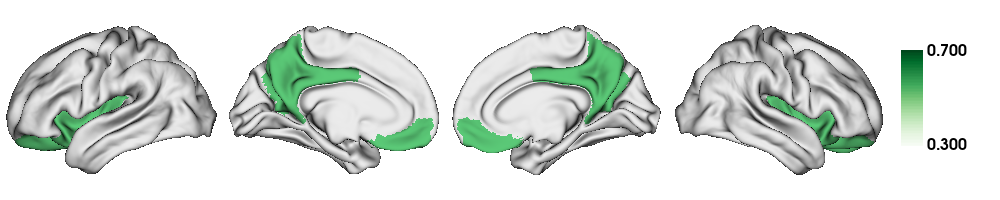

const_reg=global, reg:intermediate_amyloid: b=0.634, 95%CI=[0.533, 0.735]


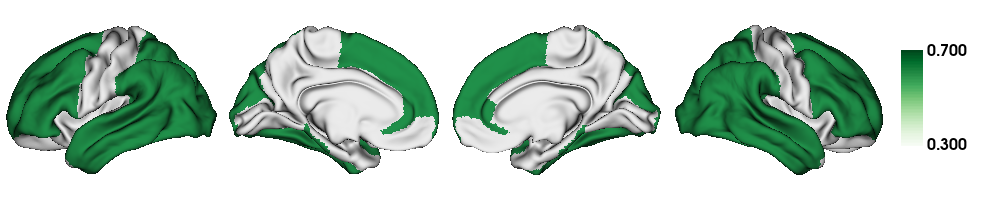

const_reg=global, reg:late_amyloid: b=0.609, 95%CI=[0.505, 0.713]


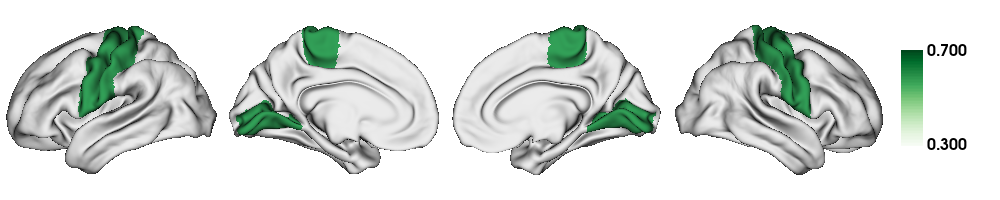

const_reg=global, reg:cho_com_I_II: b=0.443, 95%CI=[0.327, 0.559]


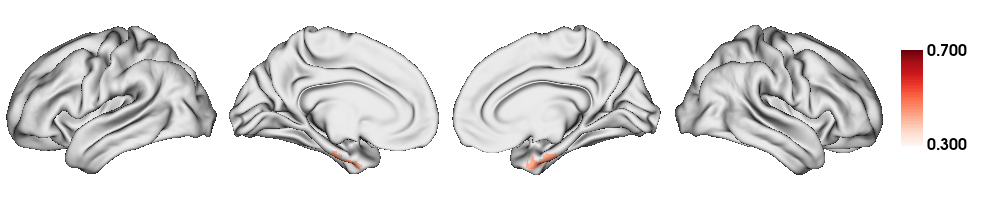

const_reg=global, reg:cho_com_III_IV: b=0.654, 95%CI=[0.555, 0.753]


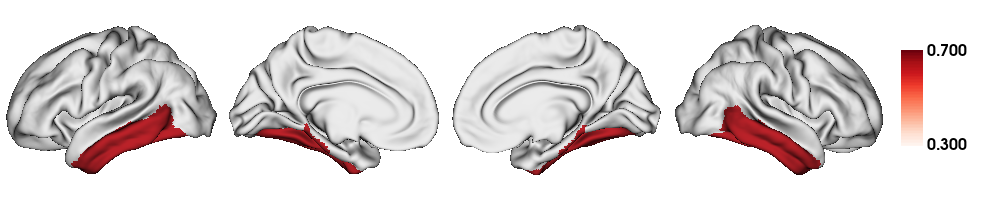

const_reg=global, reg:cho_com_V_VI: b=0.594, 95%CI=[0.488, 0.699]


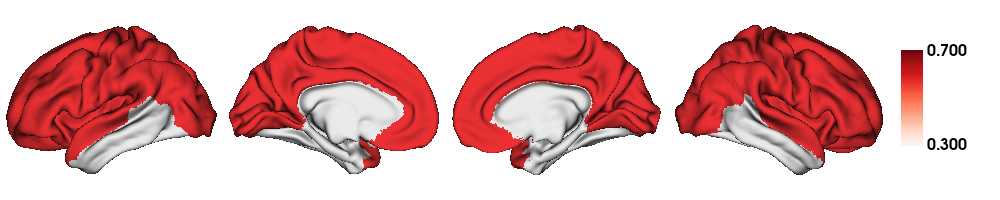

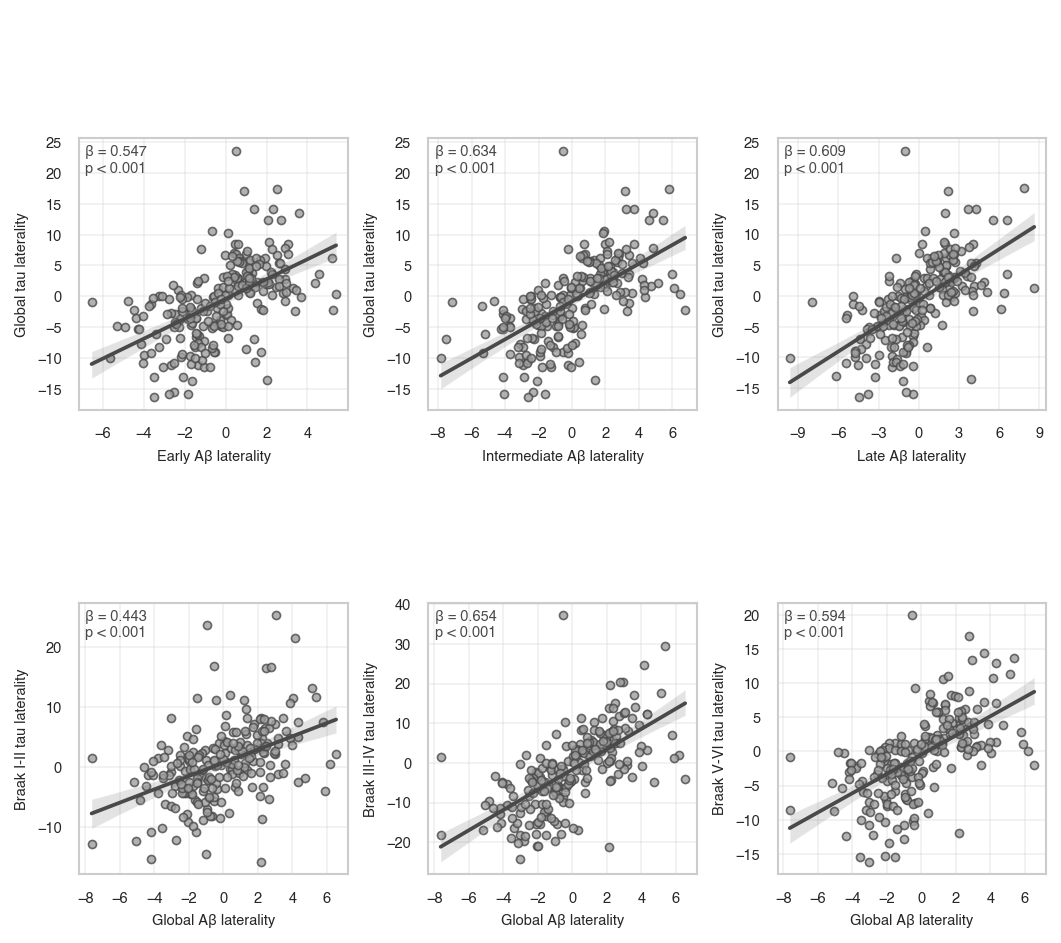

const_reg=temporal_meta, reg:early_amyloid: b=0.553, 95%CI=[0.444, 0.662]


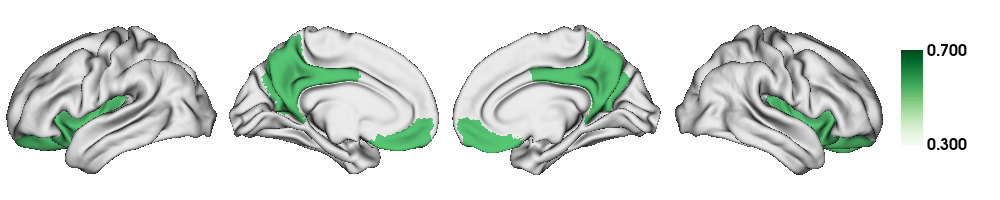

const_reg=temporal_meta, reg:intermediate_amyloid: b=0.666, 95%CI=[0.568, 0.763]


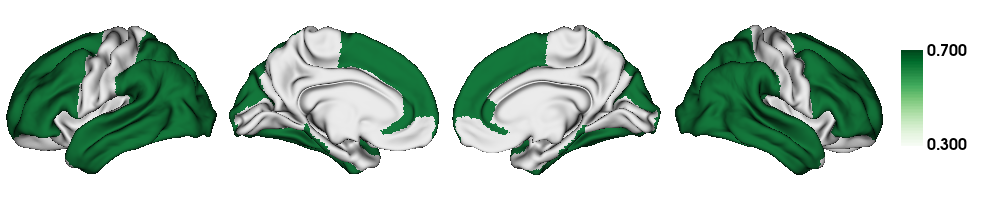

const_reg=temporal_meta, reg:late_amyloid: b=0.601, 95%CI=[0.497, 0.705]


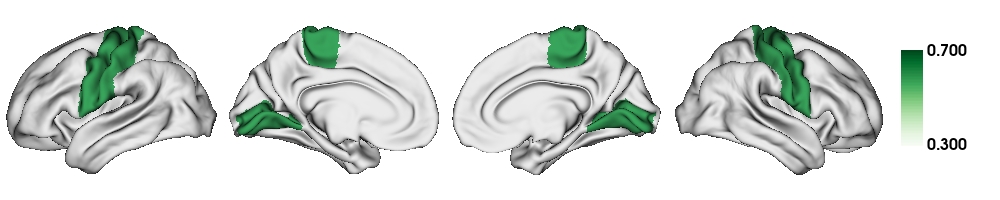

const_reg=temporal_meta, reg:cho_com_I_II: b=0.464, 95%CI=[0.348, 0.579]


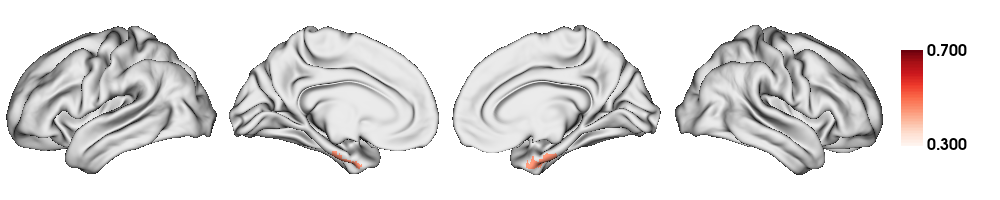

const_reg=temporal_meta, reg:cho_com_III_IV: b=0.644, 95%CI=[0.544, 0.744]


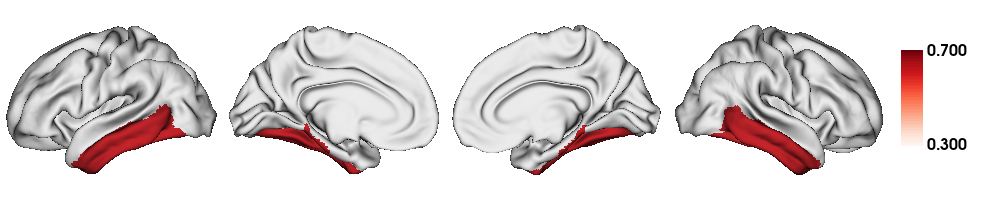

const_reg=temporal_meta, reg:cho_com_V_VI: b=0.532, 95%CI=[0.421, 0.643]


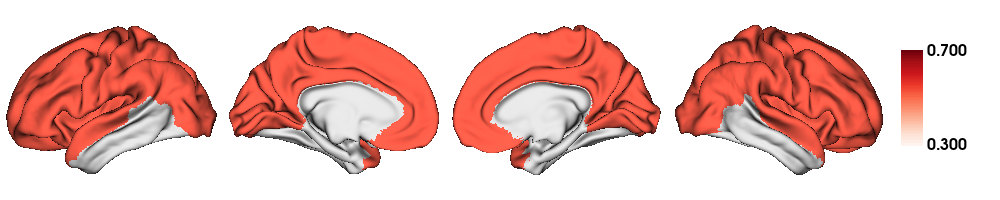

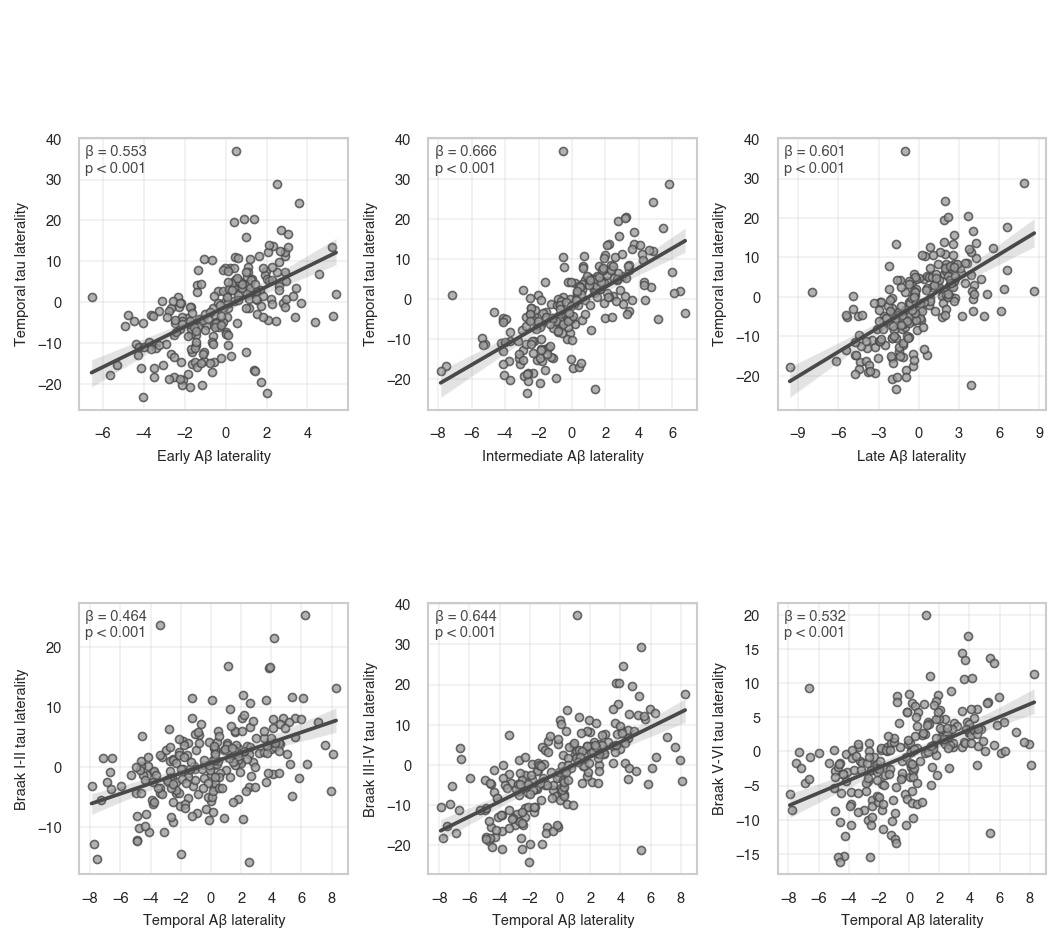

In [4]:
from matplotlib.ticker import MaxNLocator

statann_kwargs = dict(fontsize=7, color='#494949')
scatter_kwargs = dict(s=15, lw=0.8, alpha=0.8, edgecolor='#494949', color='#9f9f9f')
label_dict = {f'{tau_prefix}_temporal_meta_LI': 'Temporal tau laterality', f'{tau_prefix}_cho_com_I_II_LI': 'Braak I-II tau laterality', 
              f'{tau_prefix}_cho_com_III_IV_LI': 'Braak III-IV tau laterality', f'{tau_prefix}_cho_com_V_VI_LI': 'Braak V-VI tau laterality', 
              f'{amy_prefix}_temporal_meta_LI': 'Temporal Aβ laterality', f'{amy_prefix}_early_amyloid_LI': 'Early Aβ laterality', 
              f'{amy_prefix}_intermediate_amyloid_LI': 'Intermediate Aβ laterality', f'{amy_prefix}_late_amyloid_LI': 'Late Aβ laterality',
              f'{tau_prefix}_global_LI': 'Global tau laterality', f'{amy_prefix}_global_LI': 'Global Aβ laterality'}

for const_reg in ['global_LI', 'temporal_meta_LI']:

    reg_cols = {f'{tau_prefix}_{const_reg}': [f'{amy_prefix}_early_amyloid_LI', f'{amy_prefix}_intermediate_amyloid_LI', f'{amy_prefix}_late_amyloid_LI'],
                f'{amy_prefix}_{const_reg}': [f'{tau_prefix}_cho_com_I_II_LI', f'{tau_prefix}_cho_com_III_IV_LI', f'{tau_prefix}_cho_com_V_VI_LI']}

    df_ = df.dropna(subset=[f'{tau_prefix}_{const_reg}', f'{amy_prefix}_{const_reg}'])

    fig, axs = plt.subplots(4, 3, figsize=(180/25.4, 160/25.4), gridspec_kw={'height_ratios': [0.2, 1, 0.2, 1]})
    for j in range(3):
        axs[0, j].axis('off'), axs[2, j].axis('off')
    for i, (key_col, val_cols) in enumerate(reg_cols.items()):
        for j, val_col in enumerate(val_cols):
            # tau col on y-axis and ab col on x-axis
            if tau_prefix in key_col:
                x_col, y_col = val_col, key_col
            elif amy_prefix in key_col:
                x_col, y_col = key_col, val_col
            
            # plot in rows 1 and 3
            plot_row = 1 if i == 0 else 3
            _, axs[plot_row, j], mdl = plot_regression(df=df_, x=x_col, y=y_col, 
                                                    covars=['age', 'gender_baseline_variable'], 
                                                    standardise=True,
                                                    ax=axs[plot_row, j], 
                                                    xlabel=label_dict[x_col], 
                                                    ylabel=label_dict[y_col],
                                                    text_kwargs=statann_kwargs, 
                                                    scatter_kwargs=scatter_kwargs)
            axs[plot_row, j].xaxis.set_major_locator(MaxNLocator(integer=True))
            
            roiname = val_col.split('_', 1)[1][:-3]
            b = mdl.params[x_col].round(3)
            ci = [mdl.conf_int().loc[x_col].iloc[0].round(3), 
                  mdl.conf_int().loc[x_col].iloc[1].round(3)]
            print(f'const_reg={const_reg[:-3]}, reg:{roiname}: b={b}, 95%CI={ci}')

            cmap = 'Greens' if plot_row == 1 else 'Reds'
            surf_args = dict(data=assign_val2roi(ROIs[roiname], b), atlas='aparc', cmap=cmap, cmap_range=(0.3, 0.7))
            fig_surf = plot_surface(**surf_args, plot_kwargs=dict(nan_color=(0.8, 0.8, 0.8, 1), zoom=1.35, transparent_bg=False, scale=1))
            _ = plot_surface(**surf_args, output=os.path.join(surfplot_dir, f'surf_{key_col}_with_{val_col}_beta.png'))
            display(fig_surf)
            

    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, f'ext_OLS_ab_LI_tau_LI_rois_with_{const_reg}.pdf'), format='pdf', dpi=300)
    plt.show()